# **Capítulo 2 – Projeto de aprendizado de máquina de ponta a ponta**

*Nossa tarefa é prever o valor médio dos imóveis em distritos da Califórnia, considerando uma série de características desses distritos.*

Aluno: Guilherme Moreira Cruz Cardoso - 202104970

# Configuração

In [339]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(202104970)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Obtendo os dados

Agora, quando chamamos fetch_housing_data(), ele cria um diretório datasets/housing no seu espaço de trabalho, baixa o arquivo housing.tgz e extrai o housing.csv neste diretório.

In [242]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [243]:
fetch_housing_data()

Esta função retorna um objeto DataFrame Pandas contendo todos os dados.

In [244]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

Utilizando o método head() do DataFrame, vejamos as cinco linhas superiores.

In [245]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


O método info() é útil para a obtenção de uma rápida descrição dos dados, em especial o número total de linhas, o tipo de cada atributo e o número de valores não nulos.

In [246]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Repare que o atributo total_bedrooms tem apenas 20.433 valores não nulos, significando que 207 bairros não possuem esta característica. Cuidaremos disso mais tarde.

Podemos descobrir quais categorias existem e quantos bairros pertencem a
cada categoria utilizando o método value_counts()

In [247]:
housing["ocean_proximity"].value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


O método describe() mostra um resumo dos atributos numéricos.

In [248]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Outro método rápido de perceber o tipo de dados com o qual você está lidando é traçar um histograma para cada atributo numérico. Um histograma mostra o número de instâncias (no eixo vertical) que possuem um determinado intervalo de valores (no eixo *horizontal*).

Saving figure attribute_histogram_plots


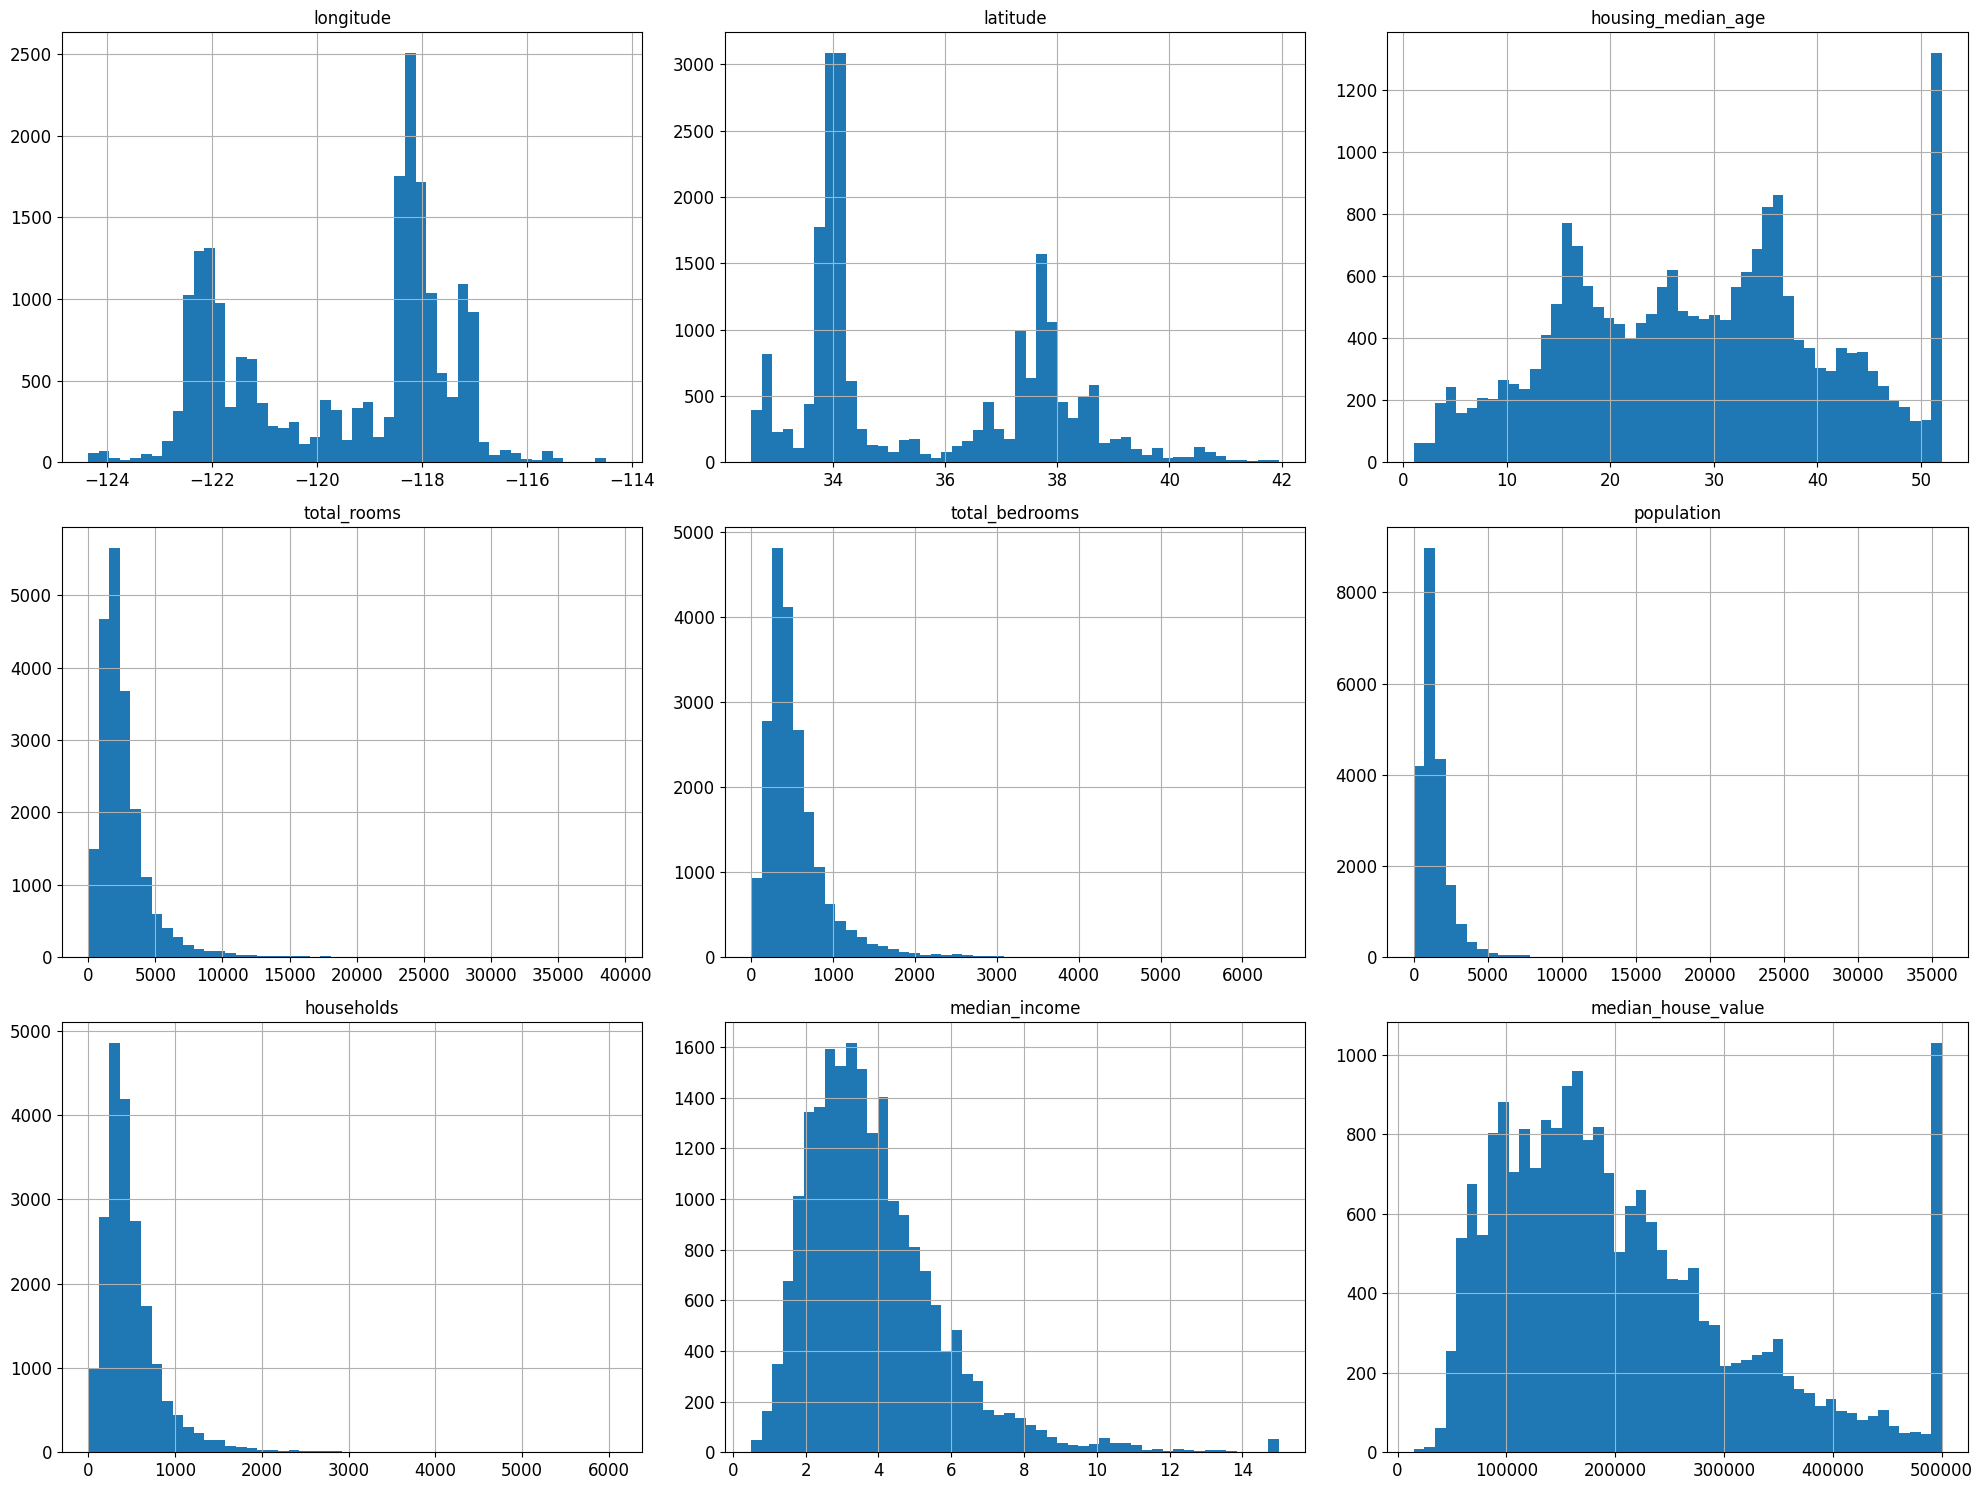

In [249]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

Vamos usar a função np.random.seed(202104970) de modo que ele sempre gere os mesmos índices embaralhados.

In [250]:
# to make this notebook's output identical at every run
np.random.seed(202104970)

Vamos criar um conjunto de testes, basta escolher aleatoriamente algumas instâncias, geralmente 20% do conjunto de dados, e colocá-las de lado.

In [251]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [252]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


In [253]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

A implementação de `test_set_check()` acima funciona bem tanto no Python 2 quanto no Python 3. Em versões anteriores, a seguinte implementação foi proposta, que suportava qualquer função hash, mas era muito mais lenta e não suportava o Python 2:

In [254]:
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

Se você quer uma implementação que suporte qualquer função hash e seja compatível com Python 2 e Python 3, aqui está uma:

In [255]:
def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

Utilizar o índice da linha como ID

In [256]:
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

Utilizar a latitude e longitude da linha como ID

In [257]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [258]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


O Scikit-Learn fornece algumas funções para dividir conjuntos de dados em vários
subconjuntos de diversas maneiras.

In [259]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=202104970)

In [260]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
11480,-118.03,33.72,24.0,5203.0,957.0,2465.0,946.0,5.1630,261000.0,<1H OCEAN
5055,-118.35,34.02,34.0,3978.0,1073.0,2725.0,1035.0,1.7622,167900.0,<1H OCEAN
8979,-118.42,34.00,45.0,1807.0,355.0,883.0,371.0,5.0357,329800.0,<1H OCEAN
10670,-117.86,33.62,17.0,2975.0,371.0,1247.0,398.0,10.1989,500001.0,<1H OCEAN
9994,-121.05,39.13,10.0,3063.0,497.0,1168.0,507.0,4.4375,185100.0,INLAND


<Axes: >

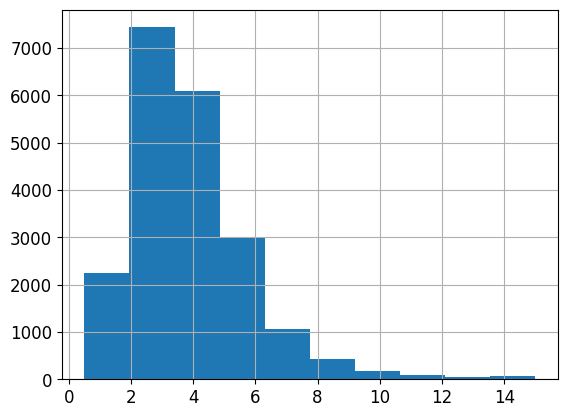

In [261]:
housing["median_income"].hist()

O código a seguir cria um atributo da categoria da renda dividindo a renda média por 1,5 (para limitar o número de categorias da renda) e arredondando com a utilização do pe.cut (para ter categorias discretas) e, em seguida, mesclando todas as categorias maiores que 5, na categoria 5:

In [262]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [263]:
housing["income_cat"].value_counts()

,count
income_cat,
3,7236
2,6581
4,3639
5,2362
1,822


<Axes: >

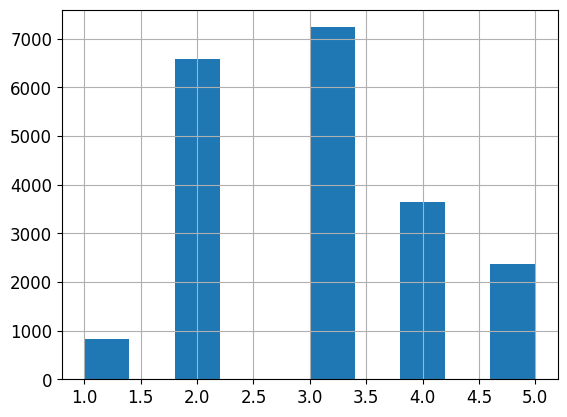

In [264]:
housing["income_cat"].hist()

Vamos a fazer uma amostragem estratificada com base na categoria
da renda.

In [265]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=202104970)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

Vamos ver se isso funcionou como esperado. Vamos começar pela análise das proporções da categoria de renda no conjunto de testes:

In [266]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

,count
income_cat,
3,0.350533
2,0.318798
4,0.176357
5,0.114341
1,0.039971


In [267]:
housing["income_cat"].value_counts() / len(housing)

,count
income_cat,
3,0.350581
2,0.318847
4,0.176308
5,0.114438
1,0.039826


In [268]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=202104970)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [269]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
income_cat,,,,,
1,0.039826,0.039971,0.038760,-2.676399,0.364964
2,0.318847,0.318798,0.322674,1.200425,-0.015195
3,0.350581,0.350533,0.341328,-2.639580,-0.013820
4,0.176308,0.176357,0.178779,1.401484,0.027480
5,0.114438,0.114341,0.118459,3.513971,-0.084674


Agora, vamos remover o atributo income_cat para que os dados voltem ao seu
estado original.

In [270]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Descubra e Visualize os Dados para Obter Informações

Criaremos uma cópia dos dados de treinamento para poder treinar com ela sem
prejudicar o conjunto de treinamento.

In [271]:
housing = strat_train_set.copy()

Visualizando Dados Geográficos

Saving figure bad_visualization_plot


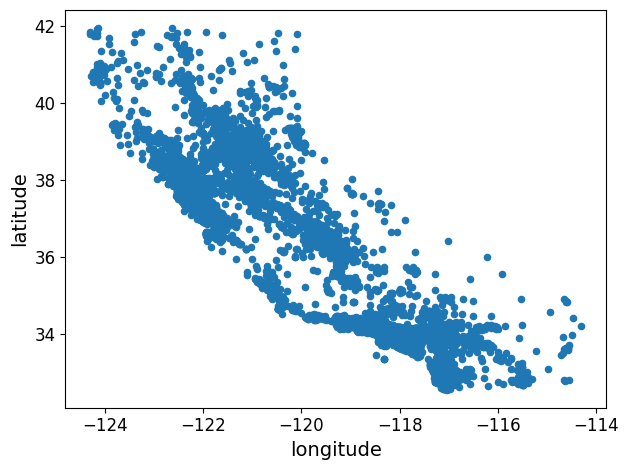

In [272]:
housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

Definir a opção alpha em 0,1 facilita a visualização dos locais onde existe uma alta densidade de pontos de dados.

Saving figure better_visualization_plot


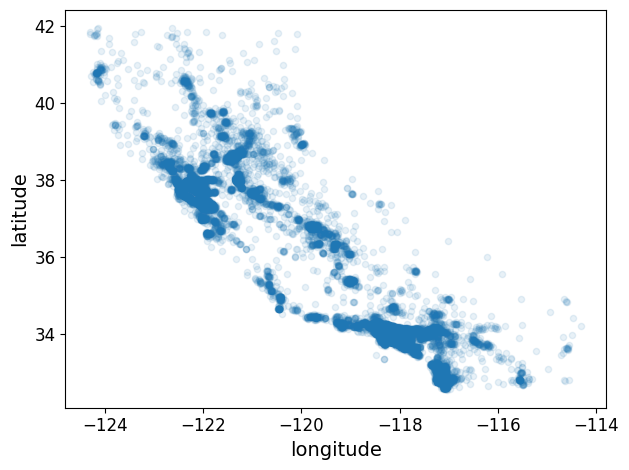

In [273]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

Agora, vejamos os preços do setor imobiliário. O raio de cada círculo representa a população do bairro e a cor representa o preço.

Saving figure housing_prices_scatterplot


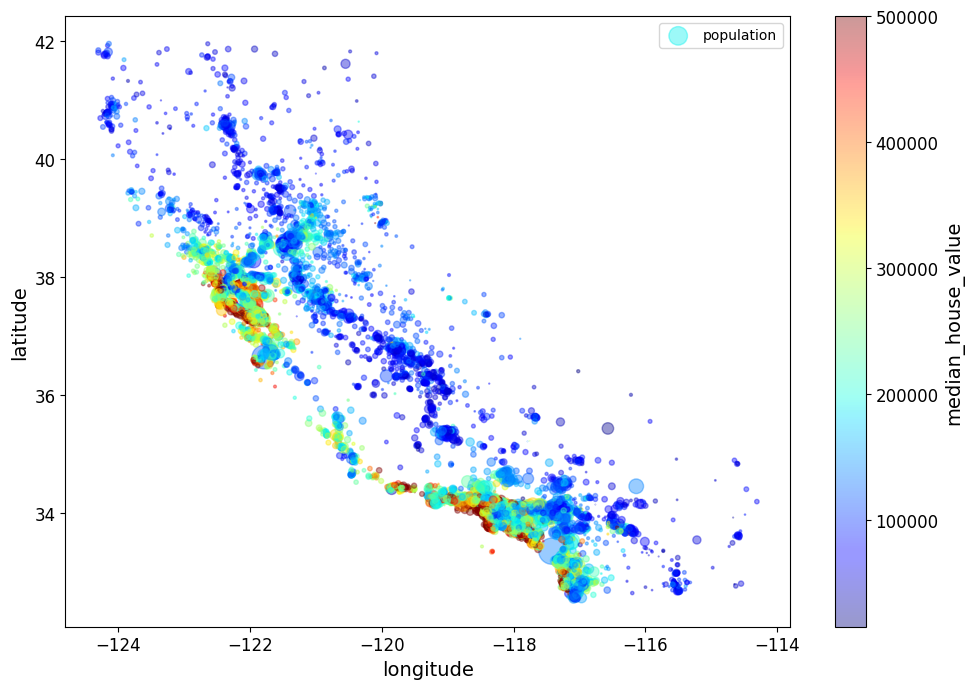

In [274]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

In [275]:
# Download the California image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/end_to_end_project/california.png',
 <http.client.HTTPMessage at 0x7b41005a1b50>)

<ipython-input-276-b4b47ed4e188>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)


Saving figure california_housing_prices_plot


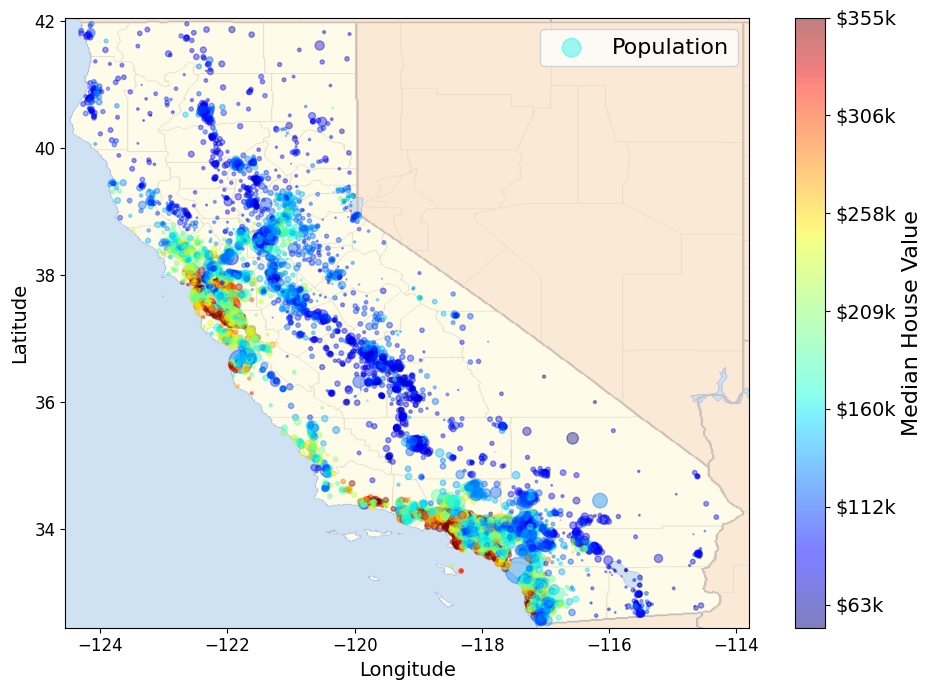

In [276]:
import matplotlib.image as mpimg
california_img=mpimg.imread(PROJECT_ROOT_DIR + '/images/end_to_end_project/california.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

# Buscando Correlações

Uma vez que o conjunto de dados não é muito grande, podemos calcular facilmente o coeficiente de correlação padrão (também chamado r de Pearson) entre cada par de atributos utilizando o método corr()

In [277]:
corr_matrix = housing.select_dtypes(include=[np.number]).corr()

Agora, vejamos o quanto cada atributo se correlaciona com o valor médio da habitação.

In [278]:
corr_matrix["median_house_value"].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.688735
total_rooms,0.135302
housing_median_age,0.109113
households,0.066291
total_bedrooms,0.049573
population,-0.023597
longitude,-0.052853
latitude,-0.138607


O coeficiente de correlação varia de -1 a 1.
*   Quando está próximo de 1, significa que existe uma forte correlação positiva
*   Quando o coeficiente está próximo de -1, significa que existe uma forte correlação negativa
*   Coeficientes próximos de zero significam que não há correlação linear.

Outra maneira de verificar a correlação entre atributos é utilizar a função
`scatter_matrix`.

Saving figure scatter_matrix_plot


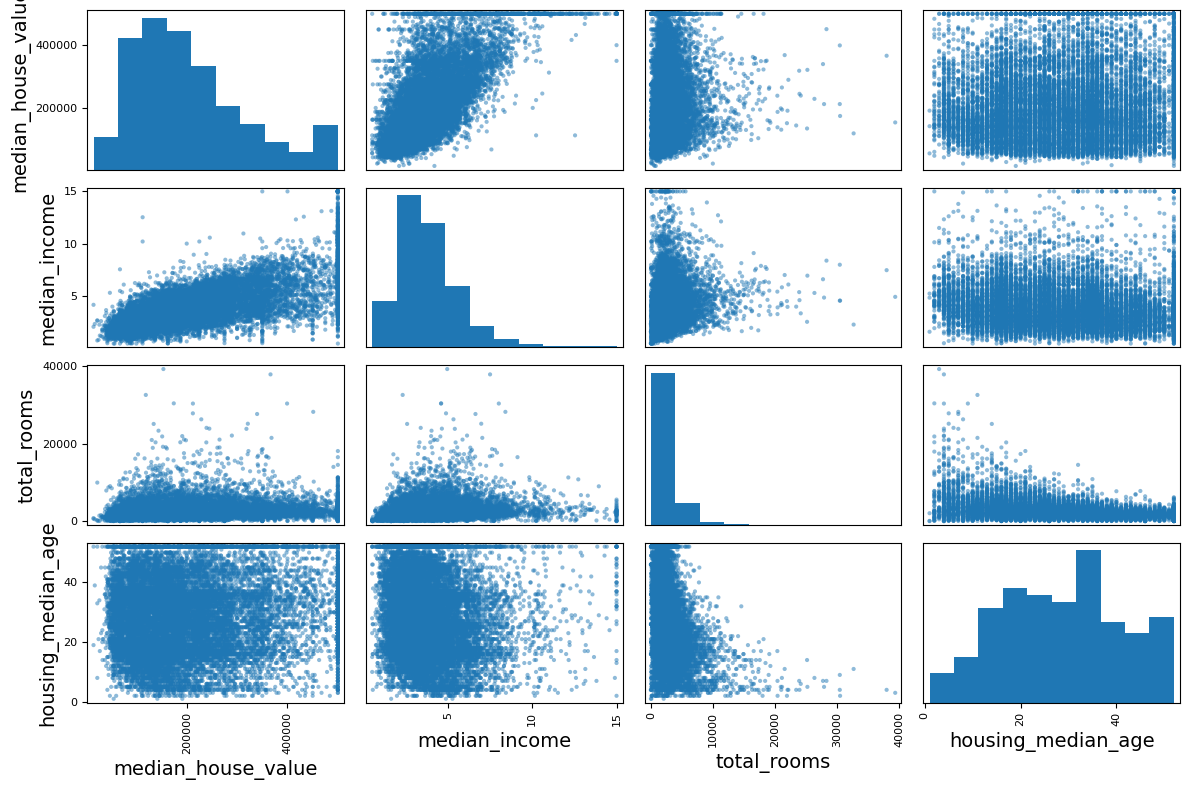

In [279]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

O atributo mais promissor para prever o valor médio da habitação é a renda média, então vamos observar o gráfico de dispersão de correlação

Saving figure income_vs_house_value_scatterplot


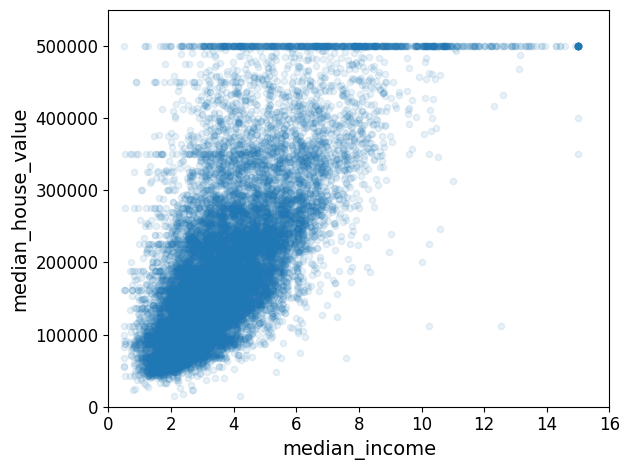

In [280]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

Experimentando com Combinações de Atributo

In [281]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [282]:
corr_matrix = housing.select_dtypes(include=[np.number]).corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.688735
rooms_per_household,0.162820
total_rooms,0.135302
housing_median_age,0.109113
households,0.066291
total_bedrooms,0.049573
population,-0.023597
population_per_household,-0.032918
longitude,-0.052853


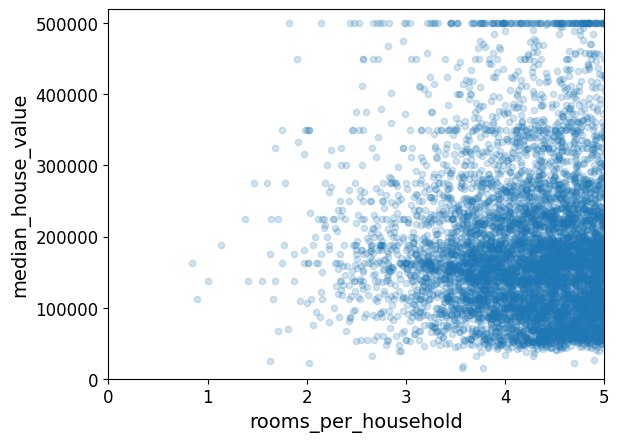

In [283]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [284]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16336.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16336.000000,16512.000000
mean,-119.569568,35.632205,28.740613,2637.568496,537.992287,1426.164910,499.815286,3.864066,206583.754663,5.424802,0.212957,3.023599
std,2.001340,2.131056,12.564841,2183.198642,423.671358,1142.065378,383.862481,1.886561,115038.993337,2.371454,0.057958,6.421613
min,-124.300000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.846154,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1446.000000,296.000000,788.000000,279.000000,2.564300,119900.000000,4.441394,0.175356,2.432108
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1165.000000,409.000000,3.533200,179700.000000,5.227388,0.203081,2.817857
75%,-118.010000,37.712500,37.000000,3163.000000,647.000000,1725.000000,606.000000,4.739700,264100.000000,6.051662,0.239690,3.281917
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,141.909091,1.000000,599.714286


# Prepare os Dados para Algoritmos do Aprendizado de Máquina

Vamos reverter para um conjunto de treinamento limpo (copiando strat_
train_set mais uma vez), e vamos separar os previsores e os rótulos, uma vez que não queremos necessariamente aplicar as mesmas transformações às previsões e aos valores-alvo (observe que drop() cria uma cópia dos dados e não afeta strat_train_set):

In [285]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

Limpando os Dados

In [286]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
9942,-122.23,38.17,45.0,350.0,NaN,225.0,72.0,1.8942,NEAR BAY
19890,-119.15,36.29,18.0,1435.0,NaN,657.0,254.0,2.4281,INLAND
14986,-117.03,32.73,34.0,2061.0,NaN,1169.0,400.0,3.5096,NEAR OCEAN
14970,-117.01,32.74,31.0,3473.0,NaN,2098.0,677.0,2.6973,<1H OCEAN
14015,-117.17,32.75,52.0,1052.0,NaN,381.0,201.0,3.0726,NEAR OCEAN


O atributo total_bedrooms tem alguns valores faltantes, então vamos
consertar isso. Há três opções:
* Livrar-se dos bairros correspondentes;
* Livrar-se de todo o atributo;
* Definir valores para algum valor (zero, a média, intermediária, etc.)

In [287]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [288]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
9942,-122.23,38.17,45.0,350.0,225.0,72.0,1.8942,NEAR BAY
19890,-119.15,36.29,18.0,1435.0,657.0,254.0,2.4281,INLAND
14986,-117.03,32.73,34.0,2061.0,1169.0,400.0,3.5096,NEAR OCEAN
14970,-117.01,32.74,31.0,3473.0,2098.0,677.0,2.6973,<1H OCEAN
14015,-117.17,32.75,52.0,1052.0,381.0,201.0,3.0726,NEAR OCEAN


In [289]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3
sample_incomplete_rows

<ipython-input-289-edae141c0e15>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
9942,-122.23,38.17,45.0,350.0,435.0,225.0,72.0,1.8942,NEAR BAY
19890,-119.15,36.29,18.0,1435.0,435.0,657.0,254.0,2.4281,INLAND
14986,-117.03,32.73,34.0,2061.0,435.0,1169.0,400.0,3.5096,NEAR OCEAN
14970,-117.01,32.74,31.0,3473.0,435.0,2098.0,677.0,2.6973,<1H OCEAN
14015,-117.17,32.75,52.0,1052.0,435.0,381.0,201.0,3.0726,NEAR OCEAN


In [290]:
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

imputer = SimpleImputer(strategy="median")

Remova o atributo de texto porque a mediana só pode ser calculada em atributos numéricos.

In [291]:
housing_num = housing.drop('ocean_proximity', axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

In [292]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [293]:
imputer.statistics_

array([-118.49  ,   34.26  ,   29.    , 2127.    ,  435.    , 1165.    ,
        409.    ,    3.5332])

Verifique se isso é o mesmo que calcular manualmente a mediana de cada atributo.

In [294]:
housing_num.median().values

array([-118.49  ,   34.26  ,   29.    , 2127.    ,  435.    , 1165.    ,
        409.    ,    3.5332])

Transforme o conjunto de treinamento:

In [295]:
X = imputer.transform(housing_num)

In [296]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)

In [297]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
9942,-122.23,38.17,45.0,350.0,435.0,225.0,72.0,1.8942
19890,-119.15,36.29,18.0,1435.0,435.0,657.0,254.0,2.4281
14986,-117.03,32.73,34.0,2061.0,435.0,1169.0,400.0,3.5096
14970,-117.01,32.74,31.0,3473.0,435.0,2098.0,677.0,2.6973
14015,-117.17,32.75,52.0,1052.0,435.0,381.0,201.0,3.0726


In [298]:
imputer.strategy

'median'

In [299]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
10255,-117.87,33.88,28.0,3333.0,752.0,2026.0,722.0,3.5667
18304,-122.12,37.41,33.0,2892.0,617.0,1250.0,581.0,5.3727
16058,-122.49,37.76,52.0,1792.0,305.0,782.0,287.0,4.0391
8889,-118.50,34.03,32.0,6365.0,1784.0,2767.0,1698.0,3.6451
940,-122.02,37.54,31.0,1240.0,264.0,719.0,236.0,3.5350


## Manipulando Texto e Atributos Categóricos

Agora vamos pré-processar o recurso de entrada categórico, `ocean_proximity`:

In [300]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
10255,<1H OCEAN
18304,NEAR BAY
16058,NEAR BAY
8889,<1H OCEAN
940,NEAR BAY
12632,INLAND
133,NEAR BAY
8535,<1H OCEAN
7018,<1H OCEAN
10790,<1H OCEAN


In [301]:
try:
    from sklearn.preprocessing import OrdinalEncoder
except ImportError:
    from future_encoders import OrdinalEncoder # Scikit-Learn < 0.20

Podemos utilizar o método factorize() do Pandas, que mapeia cada categoria para um número inteiro diferente:

In [302]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [3.],
       [3.],
       [0.],
       [3.],
       [1.],
       [3.],
       [0.],
       [0.],
       [0.]])

In [303]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Vamos programar as categorias como vetores one-hot.

In [304]:
try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

Por padrão, a classe `OneHotEncoder` retorna um array esparso, mas podemos convertê-lo em um array denso, se necessário, chamando o método `toarray()`:

In [305]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

Alternativamente, você pode definir `sparse=False` ao criar o `OneHotEncoder`:

In [306]:
cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [307]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## Customize Transformadores

Vamos criar um transformador personalizado para adicionar atributos extras:

In [308]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

Por exemplo, esta é uma pequena classe transformer que adiciona os atributos
combinados discutidos anteriormente:

In [309]:
from sklearn.base import BaseEstimator, TransformerMixin

# get the right column indices: safer than hard-coding indices 3, 4, 5, 6
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

Como alternativa, você pode usar a classe `FunctionTransformer` do Scikit-Learn, que permite criar facilmente um transformador com base em uma função de transformação (agradecimentos a [Hanmin Qin](https://github.com/qinhanmin2014) por sugerir este código). Observe que precisamos definir `validate=False` porque os dados contêm valores não flutuantes (`validate` terá como padrão `False` no Scikit-Learn 0.22).

In [310]:
from sklearn.preprocessing import FunctionTransformer

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_bedrooms_per_room": False})
housing_extra_attribs = attr_adder.fit_transform(housing.values)

In [311]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
10255,-117.87,33.88,28.0,3333.0,752.0,2026.0,722.0,3.5667,<1H OCEAN,4.616343,2.806094
18304,-122.12,37.41,33.0,2892.0,617.0,1250.0,581.0,5.3727,NEAR BAY,4.977625,2.151463
16058,-122.49,37.76,52.0,1792.0,305.0,782.0,287.0,4.0391,NEAR BAY,6.243902,2.724739
8889,-118.5,34.03,32.0,6365.0,1784.0,2767.0,1698.0,3.6451,<1H OCEAN,3.748528,1.629564
940,-122.02,37.54,31.0,1240.0,264.0,719.0,236.0,3.535,NEAR BAY,5.254237,3.04661


## Pipelines de Transformação

Agora vamos construir um pipeline para pré-processar os atributos numéricos (observe que poderíamos usar `CombinedAttributesAdder()` em vez de `FunctionTransformer(...)` se preferirmos):

In [312]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [313]:
housing_num_tr

array([[ 0.8492404 , -0.82224867, -0.05894506, ..., -0.34092285,
        -0.03387183,  0.18115923],
       [-1.27440077,  0.83425711,  0.33900278, ..., -0.18857231,
        -0.13581678, -0.00475682],
       [-1.45928247,  0.99849989,  1.85120455, ...,  0.34541072,
        -0.04654123, -0.65822522],
       ...,
       [ 1.25897823, -1.41821535,  0.17982364, ...,  0.09098396,
         0.09215802, -0.55089741],
       [-1.06453506,  1.61323717, -0.21812419, ..., -0.05972611,
        -0.02772827, -0.34087521],
       [-1.1544775 ,  0.7967159 ,  1.29407758, ..., -0.8306251 ,
         0.0184429 ,  1.47789566]])

In [314]:
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20

In [315]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [316]:
housing_prepared

array([[ 0.8492404 , -0.82224867, -0.05894506, ...,  0.        ,
         0.        ,  0.        ],
       [-1.27440077,  0.83425711,  0.33900278, ...,  0.        ,
         1.        ,  0.        ],
       [-1.45928247,  0.99849989,  1.85120455, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 1.25897823, -1.41821535,  0.17982364, ...,  0.        ,
         0.        ,  1.        ],
       [-1.06453506,  1.61323717, -0.21812419, ...,  0.        ,
         0.        ,  0.        ],
       [-1.1544775 ,  0.7967159 ,  1.29407758, ...,  0.        ,
         0.        ,  0.        ]])

In [317]:
housing_prepared.shape

(16512, 16)

Para referência, aqui está a solução antiga baseada em um transformador `DataFrameSelector` (para selecionar apenas um subconjunto das colunas `DataFrame` do Pandas) e um `FeatureUnion`:

In [318]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Agora vamos juntar todos esses componentes em um grande pipeline que pré-processará os recursos numéricos e categóricos (novamente, poderíamos usar `CombinedAttributesAdder()` em vez de `FunctionTransformer(...)` se preferirmos):

In [319]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse_output=False)),
    ])

In [320]:
from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])

In [321]:
old_housing_prepared = old_full_pipeline.fit_transform(housing)
old_housing_prepared

array([[ 0.8492404 , -0.82224867, -0.05894506, ...,  0.        ,
         0.        ,  0.        ],
       [-1.27440077,  0.83425711,  0.33900278, ...,  0.        ,
         1.        ,  0.        ],
       [-1.45928247,  0.99849989,  1.85120455, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 1.25897823, -1.41821535,  0.17982364, ...,  0.        ,
         0.        ,  1.        ],
       [-1.06453506,  1.61323717, -0.21812419, ...,  0.        ,
         0.        ,  0.        ],
       [-1.1544775 ,  0.7967159 ,  1.29407758, ...,  0.        ,
         0.        ,  0.        ]])

O resultado é o mesmo do `ColumnTransformer`:

In [322]:
np.allclose(housing_prepared, old_housing_prepared)

True

# Selecione e Treine um Modelo

Agora estamos pronto para selecionar e treinar um modelo de Aprendizado
de Máquina.

### Treinando e Avaliando o Conjunto de Treinamento

In [323]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [324]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [210133.00060036 317237.44929651 264776.72149137 338167.01852223
 213229.55702775]


Compare com os valores reais:

In [325]:
print("Labels:", list(some_labels))

Labels: [190700.0, 360900.0, 332700.0, 383300.0, 210300.0]


In [326]:
some_data_prepared

array([[ 0.8492404 , -0.82224867, -0.05894506,  0.31854754,  0.51030043,
         0.52523548,  0.57883084, -0.15762829, -0.34092285, -0.03387183,
         0.18115923,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.27440077,  0.83425711,  0.33900278,  0.11654423,  0.19003638,
        -0.15425583,  0.21150067,  0.79969838, -0.18857231, -0.13581678,
        -0.00475682,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ],
       [-1.45928247,  0.99849989,  1.85120455, -0.3873189 , -0.55012942,
        -0.56405214, -0.55442181,  0.09278207,  0.34541072, -0.04654123,
        -0.65822522,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ],
       [ 0.53444183, -0.75185891,  0.25941321,  1.70737756,  2.95854116,
         1.17407963,  3.12148506, -0.11606992, -0.70687649, -0.21709146,
         1.00901142,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.22443274,  0.89526157,  0

Vamos medir a RMSE desse modelo de regressão em todo o conjunto de treinamento com o uso da função mean_squared_error do Scikit-Learn:

In [327]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

np.float64(67940.43403358514)

In [328]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49148.23117075781

Treinaremos um DecisionTreeRegressor. Este é um modelo poderoso, capaz de encontrar relações não lineares complexas nos dados.

In [329]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=202104970)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=202104970)

Agora que o modelo está treinado, vamos avaliá-lo no conjunto de treinamento:

In [330]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

np.float64(0.0)

Nenhum erro? É muito mais provável que o modelo tenha se sobreajustado mal aos dados.

# Avaliando Melhor com a Utilização da Validação Cruzada

In [331]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

Vamos olhar os resultados:

In [332]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [76964.16916665 70858.10998157 73384.5803143  70657.0706665
 69811.55414221 74028.29628872 67364.42799414 68743.24557567
 66872.94269162 78026.9973782 ]
Mean: 71671.13941995936
Standard deviation: 3635.8711433346148


Agora a Árvore de Decisão não tem uma aparência tão boa quanto antes. Na verdade, parece ser pior do que o modelo de Regressão Linear

In [333]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [69225.99200999 71180.15506203 66693.57786025 67366.89794516
 68570.18093215 70321.36366133 67302.63046158 64425.16395794
 68923.94863739 69487.20270371]
Mean: 68349.71132315135
Standard deviation: 1858.657716242712


**Observação**: especificamos `n_estimators=10` para evitar um aviso sobre o fato de que o valor padrão mudará para 100 no Scikit-Learn 0.22.

In [334]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=202104970)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(n_estimators=10, random_state=202104970)

In [335]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

np.float64(21990.23005481493)

In [336]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51956.78568274 50749.95502433 52515.80963029 53556.38119719
 53130.30120603 50943.94357031 51543.43514912 49536.53420655
 52273.44267192 54632.72724972]
Mean: 52083.931558818396
Standard deviation: 1409.1980592628033


Isso é muito melhor: Florestas Aleatórias parecem muito promissoras. No entanto, note que a pontuação no conjunto de treinamento ainda é muito menor do que nos conjuntos de validação, o que significa que o modelo ainda está se sobreajustando ao conjunto de treinamento.

In [337]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

,0
count,10.000000
mean,68349.711323
std,1959.197258
min,64425.163958
25%,67318.697332
50%,68747.064785
75%,69421.900030
max,71180.155062


In [338]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

np.float64(110256.65860014602)

### Ajuste Seu Modelo

**Grid Search**

O código a seguir busca a melhor combinação de valores dos
hiperparâmetros para RandomForestRegressor:

In [226]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=202104970)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=202104970),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

A melhor combinação de hiperparâmetros encontrada:

In [227]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [228]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30, random_state=202104970)

Vamos dar uma olhada na pontuação de cada combinação de hiperparâmetros testada durante a pesquisa na grade:

In [229]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

61318.389671809105 {'max_features': 2, 'n_estimators': 3}
54189.35551137925 {'max_features': 2, 'n_estimators': 10}
52223.90145560667 {'max_features': 2, 'n_estimators': 30}
59853.3339545673 {'max_features': 4, 'n_estimators': 3}
52021.699166864826 {'max_features': 4, 'n_estimators': 10}
50019.217754859346 {'max_features': 4, 'n_estimators': 30}
58209.169944360256 {'max_features': 6, 'n_estimators': 3}
51659.95025464278 {'max_features': 6, 'n_estimators': 10}
49286.578099982406 {'max_features': 6, 'n_estimators': 30}
58070.4215024827 {'max_features': 8, 'n_estimators': 3}
51676.76438817713 {'max_features': 8, 'n_estimators': 10}
49424.68767639001 {'max_features': 8, 'n_estimators': 30}
60268.46655957365 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
52624.38024720126 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59796.822546968804 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
51869.705103534056 {'bootstrap': False, 'max_features': 3, 'n_estimators

In [230]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.104392,0.005114,0.005628,0.000132,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.589632e+09,-3.878712e+09,...,-3.759945e+09,1.097147e+08,18,-1.005403e+09,-1.069658e+09,-1.025319e+09,-1.089174e+09,-1.005668e+09,-1.039044e+09,3.430555e+07
1,0.335035,0.002727,0.015174,0.000827,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-2.958356e+09,-2.852127e+09,...,-2.936486e+09,9.940459e+07,11,-5.674135e+08,-5.586465e+08,-5.582115e+08,-5.753128e+08,-5.512991e+08,-5.621767e+08,8.324524e+06
2,1.114097,0.157984,0.051043,0.005633,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.744187e+09,-2.688408e+09,...,-2.727336e+09,1.226824e+08,9,-4.300680e+08,-4.279112e+08,-4.279088e+08,-4.288525e+08,-4.189315e+08,-4.267344e+08,3.981183e+06
3,0.199601,0.030624,0.006595,0.001000,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.532928e+09,-3.566604e+09,...,-3.582422e+09,1.897140e+08,16,-9.785887e+08,-9.193220e+08,-9.770078e+08,-9.295659e+08,-9.419976e+08,-9.492964e+08,2.435977e+07
4,0.544467,0.004447,0.014345,0.000111,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.702636e+09,-2.656259e+09,...,-2.706257e+09,1.145180e+08,8,-5.051134e+08,-4.986156e+08,-5.122844e+08,-5.217649e+08,-4.874926e+08,-5.050542e+08,1.167384e+07
5,1.806062,0.165587,0.044780,0.004502,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.508161e+09,-2.467424e+09,...,-2.501922e+09,9.607595e+07,3,-3.899189e+08,-3.762082e+08,-3.843306e+08,-3.903083e+08,-3.705214e+08,-3.822575e+08,7.773565e+06
6,0.237771,0.005463,0.007107,0.000716,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.483915e+09,-3.448245e+09,...,-3.388307e+09,1.124441e+08,14,-8.925100e+08,-9.003499e+08,-8.576127e+08,-8.907049e+08,-8.845390e+08,-8.851433e+08,1.466110e+07
7,0.796173,0.013322,0.015806,0.001359,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.703765e+09,-2.674330e+09,...,-2.668750e+09,1.061440e+08,5,-4.870028e+08,-4.961733e+08,-4.938580e+08,-4.946967e+08,-4.797079e+08,-4.902878e+08,6.157096e+06
8,2.508310,0.178057,0.044375,0.003109,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.428179e+09,-2.474845e+09,...,-2.429167e+09,8.661101e+07,1,-3.767329e+08,-3.788689e+08,-3.739596e+08,-3.794952e+08,-3.646841e+08,-3.747482e+08,5.391882e+06
9,0.318831,0.013453,0.007573,0.001418,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.346291e+09,-3.227909e+09,...,-3.372174e+09,1.480929e+08,13,-8.611262e+08,-8.873921e+08,-8.856701e+08,-8.826106e+08,-9.048118e+08,-8.843222e+08,1.394309e+07


In [231]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=202104970)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=202104970)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(random_state=202104970),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b40fd826890>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b40fd825b50>},
                   random_state=202104970, scoring='neg_mean_squared_error')

In [232]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49009.205742556245 {'max_features': 7, 'n_estimators': 50}
48484.191411505744 {'max_features': 6, 'n_estimators': 183}
49005.49389357148 {'max_features': 4, 'n_estimators': 156}
54404.73199883439 {'max_features': 1, 'n_estimators': 55}
53798.38617632463 {'max_features': 1, 'n_estimators': 115}
48621.18834239753 {'max_features': 5, 'n_estimators': 152}
52483.81643074926 {'max_features': 4, 'n_estimators': 9}
49907.228301110095 {'max_features': 5, 'n_estimators': 29}
49718.47703639085 {'max_features': 3, 'n_estimators': 153}
48486.43741736543 {'max_features': 6, 'n_estimators': 187}


### Analise os Melhores Modelos e Seus Erros

`RandomForestRegressor` pode indicar a importância relativa de
cada atributo para fazer previsões precisas

In [233]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.96605816e-02, 7.04986946e-02, 4.19692179e-02, 1.78729612e-02,
       1.61377149e-02, 1.76918673e-02, 1.65453892e-02, 3.01908670e-01,
       7.70808454e-02, 1.06917881e-01, 7.48894069e-02, 1.25747619e-02,
       1.56828911e-01, 1.94470267e-04, 4.32403010e-03, 4.90459644e-03])

Mostraremos essas pontuações de importância ao lado de seus nomes de atributos
correspondentes:

In [234]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(np.float64(0.3019086699581162), 'median_income'),
 (np.float64(0.15682891101797233), 'INLAND'),
 (np.float64(0.10691788124283955), 'pop_per_hhold'),
 (np.float64(0.07966058156501986), 'longitude'),
 (np.float64(0.07708084540784045), 'rooms_per_hhold'),
 (np.float64(0.07488940693496371), 'bedrooms_per_room'),
 (np.float64(0.07049869462463275), 'latitude'),
 (np.float64(0.04196921791384188), 'housing_median_age'),
 (np.float64(0.01787296124176099), 'total_rooms'),
 (np.float64(0.017691867262543574), 'population'),
 (np.float64(0.016545389157848492), 'households'),
 (np.float64(0.016137714918284432), 'total_bedrooms'),
 (np.float64(0.012574761944570445), '<1H OCEAN'),
 (np.float64(0.004904596438574838), 'NEAR OCEAN'),
 (np.float64(0.004324030103917647), 'NEAR BAY'),
 (np.float64(0.0001944702672728376), 'ISLAND')]

### Avaliação do Sistema no Conjunto de Testes

In [235]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [236]:
final_rmse

np.float64(49864.637520496246)

Isso quer dizer que, em média, o modelo erra o valor da casa em cerca de 49.864 dólares, o que é um valor muito alto.

Podemos calcular um intervalo de confiança de 95% para o teste RMSE:

In [237]:
from scipy import stats

In [238]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=stats.sem(squared_errors)))

array([47558.49922044, 52068.73632037])

Poderíamos calcular o intervalo manualmente assim:

In [239]:
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(np.float64(47558.499220437625), np.float64(52068.736320373646))

Alternativamente, poderíamos usar pontuações z em vez de pontuações t:

In [240]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(np.float64(47559.19195325956), np.float64(52068.10358419034))